## **Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

### Name: Syed Muzammil Syed Riyaz Ahamed
### Student Id: 9012161
### Section: 2

### **Objective:**

##### In this lab, the goal is to develop and evaluate models that effectively classify images of dogs and cats, leveraging both a custom-designed neural network and transfer learning using a pre-trained model, VGG16. This exercise will help in understanding the process of building and fine-tuning deep learning models on a specific task with proper evaluation and insights into the performance of the model.

### **Importing Libraries**

In [3]:
import os, shutil, pathlib

from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, ConfusionMatrixDisplay

### **Code Reference:**

- #### [05A_asirra_the_dogs_vs_cats_dataset.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05A_asirra_the_dogs_vs_cats_dataset.ipynb)
- #### [05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb)
- #### [05D_fine_tuning_vgg16.ipynb](https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05D_fine_tuning_vgg16.ipynb)

### **Getting the Data**

#### The dataset can be obtained from: [Kaggle - Dogs versus Cats](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats)

### **Exploratory Data Analysis:**

### **1. Loading the data**


In [4]:
data_folder = pathlib.Path('D:\CSCN8010-Labs\kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [5]:
# Count images in each class
train_dir = data_folder / "train"
class_counts = {folder.name: len(list(folder.glob("*.jpg"))) for folder in train_dir.iterdir()}
print("Class counts:", class_counts)


Class counts: {'cat': 1000, 'dog': 1000}


### **2. Visualize Class Distribution**

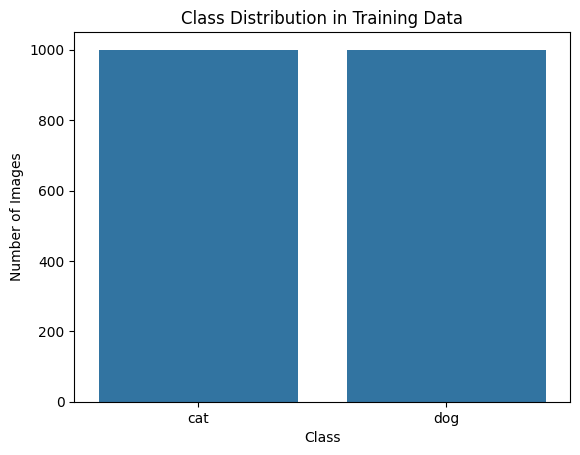

In [6]:
# Visualize class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


#### This is the bar chart of class distribution in the training data, showing the number of images for the "cat" and "dog" classes.

- #### One can clearly observe that both classes are roughly balanced, with close to 1,000 images in each class.

- #### A balanced dataset ensures that the model does not get biased toward one class both during training and evaluation; thus, the classification will be fair.

#### The reason this balance is important is that it helps to come up with good performance metrics such as accuracy, precision, and recall that do not bias one category over the other. It also simplifies training models since no extra steps are taken in order to take care of the class imbalance issues through oversampling or undersampling.

### **3. Image Dimensions and Statistics**

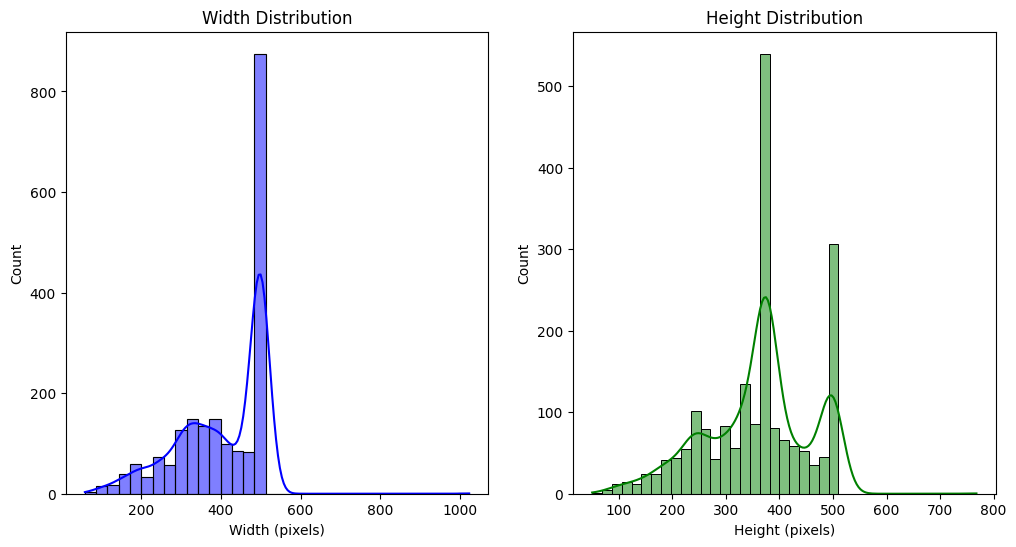

In [7]:
# Analyze image dimensions
image_shapes = []
for img_path in train_dir.glob("*/*.jpg"):
    with Image.open(img_path) as img:
        image_shapes.append(img.size)

# Convert to numpy array
image_shapes = np.array(image_shapes)
widths, heights = image_shapes[:, 0], image_shapes[:, 1]

# Plot distributions of width and height
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, color='blue')
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, color='green')
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.show()


#### These two histograms represent the distribution of widths and heights in the dataset.

- #### **Width Distribution:** Most of the images have a width close to 500 pixels, although some are as small as 100-200 pixels. A spike here represents a coherent image size across many samples.

- #### **Height Distribution:** Similarly, the height of most images is around 400-500 pixels while other, smaller dimensions make up a few images each. A few peaks mark the dominant image size in this dataset.

#### These kinds of distribution convey that the resizing of images to some standard size would be necessary for the neural network to have some consistent input. The diversity could indicate a number of sources of the images.

### **4. Sample Images**

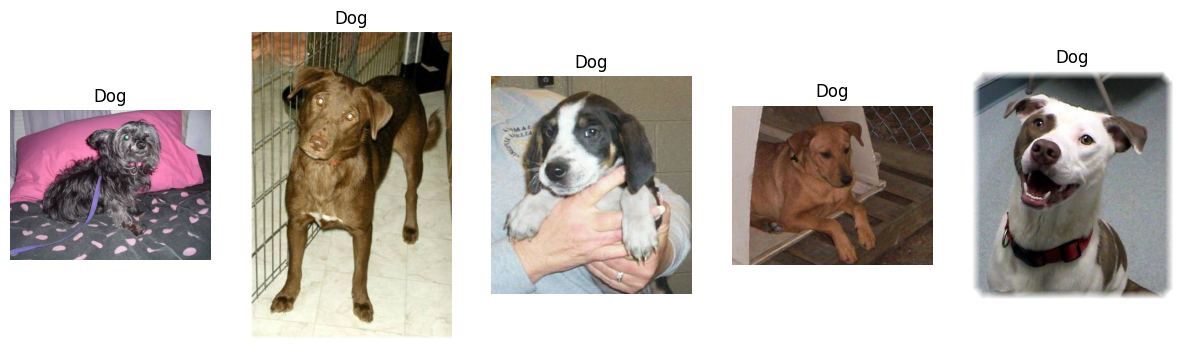

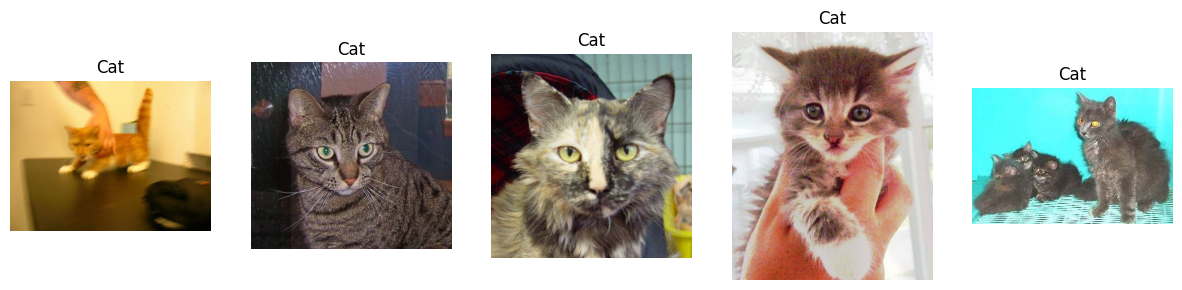

In [8]:
def show_sample_images(data_path, class_name, num_images=5):
    # Convert data_path to a Path object if it's not already
    data_path = Path(data_path)
    class_path = data_path / class_name
    sample_images = list(class_path.glob("*.jpg"))[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name.capitalize())
    plt.show()

# Display sample images
show_sample_images("D:\\CSCN8010-Labs\\kaggle_dogs_vs_cats_small\\train", "dog", 5)
show_sample_images("D:\\CSCN8010-Labs\\kaggle_dogs_vs_cats_small\\train", "cat", 5)


#### Following is sample images from the "Dogs vs Cats" dataset, which has two classes: "dog" and "cat." Each set consists of 5 randomly chosen images from the given directory. In this way, it becomes clear how the variation in the dataset is great visually because of different breeds, positions, and light conditions. Different dogs are shown for a class "dog" each in a different environment. Similarly, the "cat" class shows various cats. The following exploration provides some insight into the dataset variability and challenges such as angles, lighting, and also possibly noise, which could mean blurry or occluded images-a very important consideration when training a classification model.

### **Convolutional Neural Network (CNN)**

### **Defining a model for Convolutional Neural Network**

#### A Convolutional Neural Network is a deep learning architecture that is specially meant for the processing and analysis of visual data such as images. It follows that the human brain processes data in a hierarchical automatic feature extraction for making predictions, including edges, shapes, and textures.

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_cnn = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

- #### The summary of the model shows the architecture, listing for each layer its type, shape of output, and number of trainable parameters.
- #### Insights from this include that as layers progress, the size of feature maps decreases and conversely the number of learned features increases.
- #### There is only one neuron in the final output layer because it classifies binary, with a sigmoid activation.

#### **Model Compilation:**

In [11]:
model_cnn.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

- #### Loss Function: `binary_crossentropy` because it is a binary classification problem, where there are two classes: cats versus dogs.

- #### Optimum: `rmsprop` because it updates weights efficiently in the case of non-stationary objectives.

- #### Metric: Accuracy is the metric whereby the model assesses its performance.

#### **Callbacks for Saving the Best Model & Model training:**

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_cnn.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 30s 468ms/step - loss: 0.7083 - accuracy: 0.5085 - val_loss: 0.9205 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 29s 462ms/step - loss: 0.6962 - accuracy: 0.5260 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 28s 443ms/step - loss: 0.6896 - accuracy: 0.5635 - val_loss: 0.6700 - val_accuracy: 0.5770
Epoch 4/30
63/63 [==============================] - 28s 446ms/step - loss: 0.6669 - accuracy: 0.6100 - val_loss: 0.6560 - val_accuracy: 0.5950
Epoch 5/30
63/63 [==============================] - 28s 446ms/step - loss: 0.6423 - accuracy: 0.6380 - val_loss: 0.6515 - val_accuracy: 0.6140
Epoch 6/30
63/63 [==============================] - 28s 445ms/step - loss: 0.5970 - accuracy: 0.6765 - val_loss: 0.6248 - val_accuracy: 0.6370
Epoch 7/30
63/63 [==============================] - 28s 446ms/step - loss: 0.5777 - accuracy: 0.6960 - val_loss: 0.6840 - val_accuracy: 0.6250

#### Callbacks for Saving the Best Model:
- #### This will ensure that, at any given time, the model with minimum validation loss during training is saved to ./models/convnet_from_scratch.keras.

- #### The best-performing model according to the validation set prevents overfitting.

#### Model training:
- #### The model trains in 30 epochs using the train_dataset and validates on the validation_dataset at the end of every epoch.

- #### The history object keeps relevant metrics from the training/validation loss and accuracy per epoch, so one can visualize performance.

### **Evaluating CNN model**

In [13]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Accuracy**

In [14]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 94ms/step - loss: 0.6255 - accuracy: 0.7100
Test accuracy: 0.710


#### **Confusion Metric**

63/63 [==============================] - 7s 101ms/step


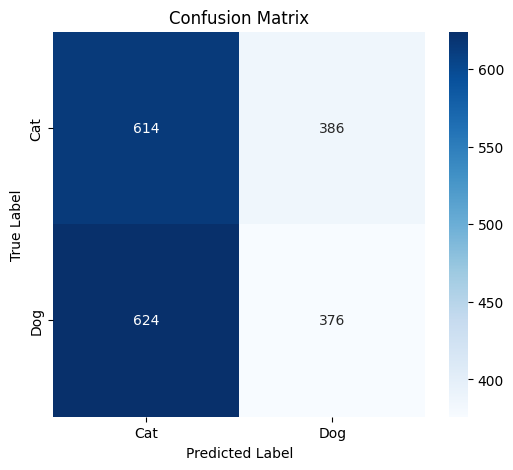

In [15]:
# Get predictions from the model
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred_probs = test_model.predict(test_dataset)               # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)                     # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



#### **Classification Report (Precision, Recall, F1-score)**

In [16]:
# Classification Report: Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.61      0.55      1000
         Dog       0.49      0.38      0.43      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



#### **Precision-Recall Curve**

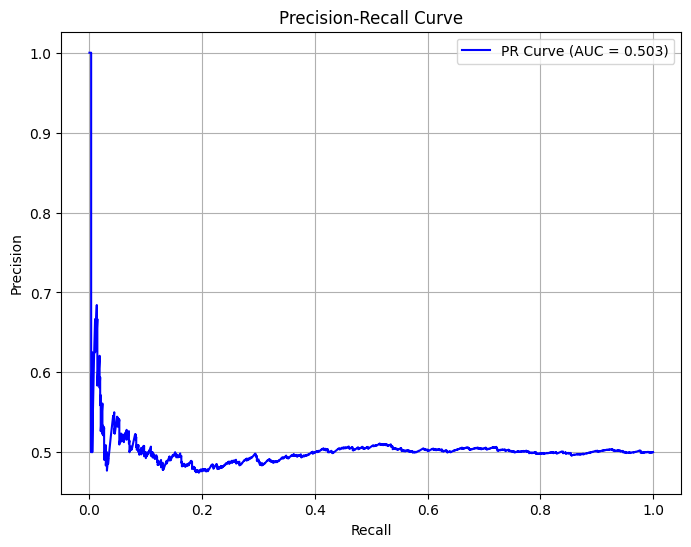

In [17]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

#### **Exploring examples in which the model failed to predict correctly**

63/63 [==============================] - 7s 102ms/step


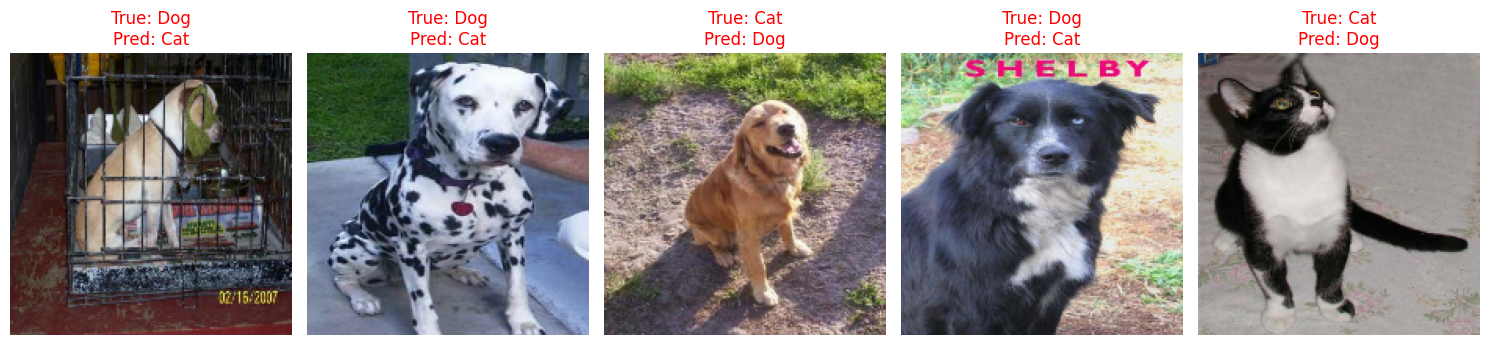

In [18]:
# Get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = test_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

# Identify misclassified examples
misclassified_indices = np.where(y_true != y_pred.ravel())[0]

# Load test images
test_images = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)

# Display some misclassified examples
num_examples = min(5, len(misclassified_indices))  # Show up to 5 examples
plt.figure(figsize=(15, 5))

for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))  # Show the misclassified image
    true_label = "Dog" if y_true[idx] == 1 else "Cat"
    predicted_label = "Dog" if y_pred[idx] == 1 else "Cat"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


### **Data Augmentation in CNN**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### **Displaying some randomly augmented training images**

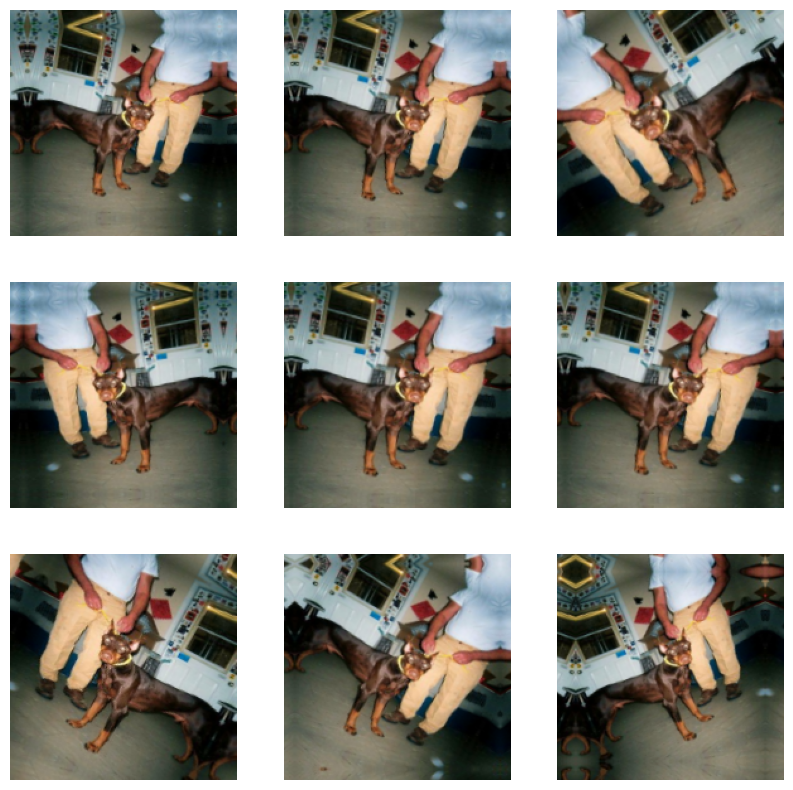

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 31s 482ms/step - loss: 0.6958 - accuracy: 0.5065 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 31s 491ms/step - loss: 0.6942 - accuracy: 0.5045 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 31s 497ms/step - loss: 0.6879 - accuracy: 0.5480 - val_loss: 0.6797 - val_accuracy: 0.5660
Epoch 4/50
63/63 [==============================] - 31s 487ms/step - loss: 0.6782 - accuracy: 0.5870 - val_loss: 0.6728 - val_accuracy: 0.5970
Epoch 5/50
63/63 [==============================] - 31s 488ms/step - loss: 0.6659 - accuracy: 0.5950 - val_loss: 0.6464 - val_accuracy: 0.6440
Epoch 6/50
63/63 [==============================] - 31s 499ms/step - loss: 0.6517 - accuracy: 0.6195 - val_loss: 0.7283 - val_accuracy: 0.5730
Epoch 7/50
63/63 [==============================] - 31s 489ms/step - loss: 0.6442 - accuracy: 0.6415 - val_loss: 0.6395 - val_accuracy: 0.6370

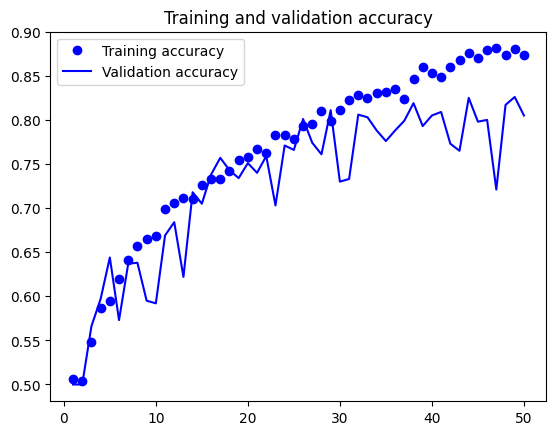

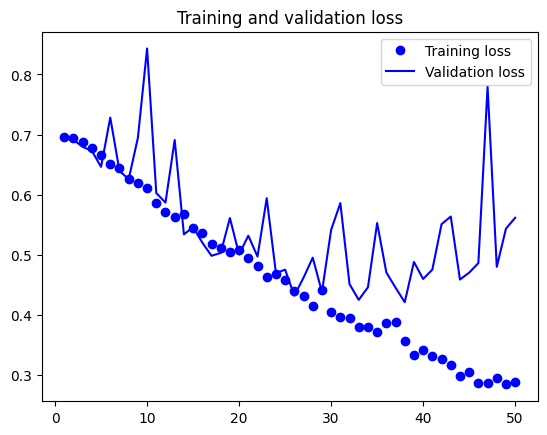

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Accuracy**

In [25]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 99ms/step - loss: 0.4577 - accuracy: 0.8005
Test accuracy: 0.800


#### **Confusion Metric**

63/63 [==============================] - 6s 100ms/step


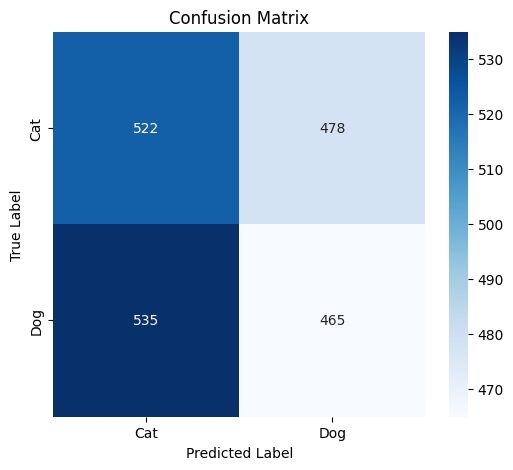

In [26]:
# Get predictions from the model
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # True labels
y_pred_probs = test_model.predict(test_dataset)               # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)                     # Convert probabilities to binary predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### **Classification Report (Precision, Recall, F1-score)**

In [27]:
# Classification Report: Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.49      0.52      0.51      1000
         Dog       0.49      0.47      0.48      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



#### **Precision-Recall Curve**

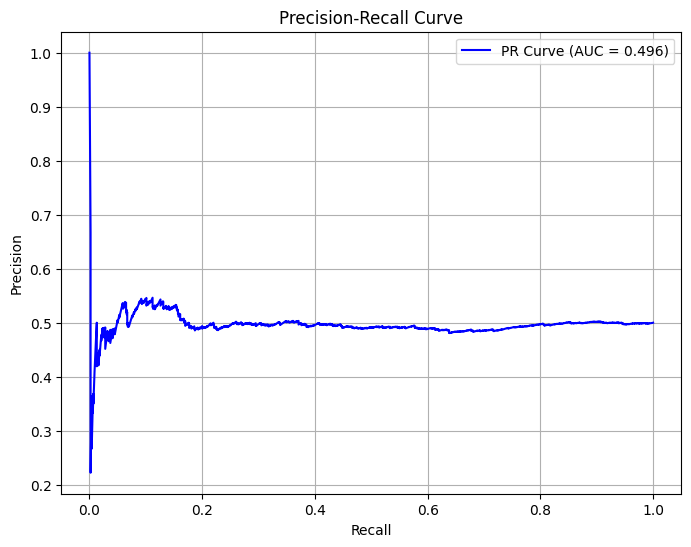

In [28]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

#### **Exploring examples in which the model failed to predict correctly**

63/63 [==============================] - 6s 100ms/step


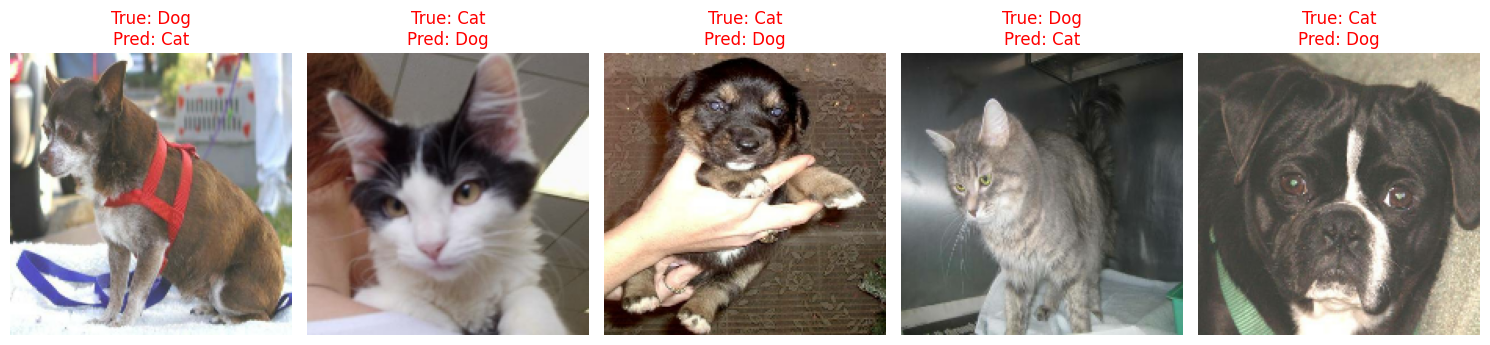

In [29]:
# Get true labels and predicted probabilities
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_probs = test_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

# Identify misclassified examples
misclassified_indices = np.where(y_true != y_pred.ravel())[0]

# Load test images
test_images = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)

# Display some misclassified examples
num_examples = min(5, len(misclassified_indices))  # Show up to 5 examples
plt.figure(figsize=(15, 5))

for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(test_images[idx].astype("uint8"))  # Show the misclassified image
    true_label = "Dog" if y_true[idx] == 1 else "Cat"
    predicted_label = "Dog" if y_pred[idx] == 1 else "Cat"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


### **VGG16**

### **Defining a model for VGG16**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [31]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 599ms/step


In [32]:
train_features.shape

(2000, 5, 5, 512)

In [33]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_vgg16 = keras.Model(inputs, outputs)

In [34]:
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_vgg16.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model_vgg16.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 19ms/step - loss: 15.1746 - accuracy: 0.9225 - val_loss: 6.6183 - val_accuracy: 0.9560
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 4.0205 - accuracy: 0.9770 - val_loss: 4.9318 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 2.0571 - accuracy: 0.9855 - val_loss: 5.1649 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 0.3827 - accuracy: 0.9935 - val_loss: 5.7330 - val_accuracy: 0.9700
Epoch 5/20
63/63 [==============================] - 1s 18ms/step - loss: 1.6709 - accuracy: 0.9895 - val_loss: 4.3937 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 0.8336 - accuracy: 0.9920 - val_loss: 7.0351 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 1.0127 - accuracy: 0.9925 - val_loss: 5.5254 - val_accuracy: 0.9740
Epoch 8/20
6

### **Evaluating VGG16 model** 

In [37]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Evaluating the VGG16 model**

#### **Accuracy**

In [38]:
test_model = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 3ms/step - loss: 6.4441 - accuracy: 0.9715
Test accuracy: 0.971


#### **Confusion Metric**

63/63 [==============================] - 0s 2ms/step


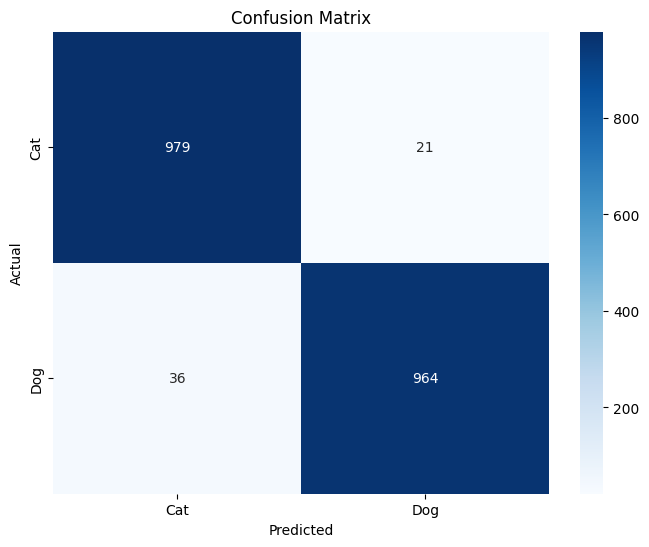

In [74]:
# Evaluate model predictions
predictions = test_model.predict(test_features)  # Get predicted probabilities
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary predictions

# 1. Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### **Precision, Recall, and F1-Score**

In [ ]:
print("Classification Report:")
print(classification_report(test_labels, predicted_classes, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.98      0.97      1000
         Dog       0.98      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



#### **Precision-Recall Curve**

In [76]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


#### **Exploring examples in which the model failed to predict correctly**

In [78]:
# Display a few misclassified examples
num_examples = 5  # Change as needed
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_examples]):
    plt.subplot(1, num_examples, i + 1)
    # Use the original images for visualization
    img = test_images[idx]  # Replace `test_images` with the original image array
    plt.imshow(img.astype("uint8"))  # Ensure proper data type for image visualization
    plt.title(f"True: {test_labels[idx]}, Pred: {predicted_classes[idx][0]}")
    plt.axis("off")
plt.show()


### **Data Augmentation**

### **Fine-tuning a pretrained model**

In [121]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [122]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0   

#### Freezing all layers until the fourth from the last

In [123]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

#### Fine-tuning the model

In [134]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 132s 2s/step - loss: 0.1391 - accuracy: 0.9625 - val_loss: 0.1339 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 131s 2s/step - loss: 0.1074 - accuracy: 0.9715 - val_loss: 0.1364 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 263s 4s/step - loss: 0.0796 - accuracy: 0.9770 - val_loss: 0.1419 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 132s 2s/step - loss: 0.0660 - accuracy: 0.9765 - val_loss: 0.1716 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 551s 9s/step - loss: 0.0840 - accuracy: 0.9755 - val_loss: 0.1790 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 132s 2s/step - loss: 0.0626 - accuracy: 0.9815 - val_loss: 0.1680 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 130s 2s/step - loss: 0.0675 - accuracy: 0.9795 - val_loss: 0.1728 - val_accuracy: 0.9750
Epoch 8/30
63

In [135]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### **Accuracy**

In [136]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 75s 1s/step - loss: 0.1412 - accuracy: 0.9695
Test accuracy: 0.970


#### **Confusion Matrix**

In [147]:
# Obtain true labels and predictions
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
pred_probs = model.predict(test_dataset)  # Probabilities from the model
predictions = (pred_probs > 0.5).astype("int32")  # Thresholding at 0.5

# 1. Confusion Matrix
cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

63/63 [==============================] - 77s 1s/step


#### **Precision, Recall, and F1-Score**

In [148]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="binary")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Precision: 0.482
Recall: 0.477
F1-Score: 0.480


#### **Precision-Recall Curve**

In [149]:
disp = PrecisionRecallDisplay.from_predictions(true_labels, pred_probs, name="Model Precision-Recall")
plt.title("Precision-Recall Curve")
plt.show()


#### **Exploring examples in which the model failed to predict correctly**

Number of misclassified examples: 1035


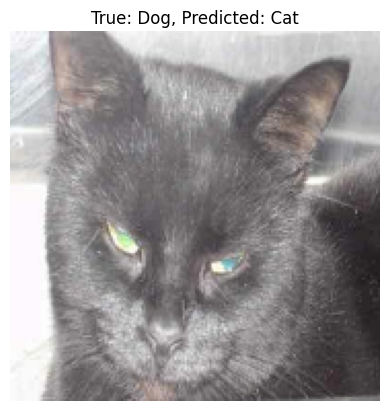

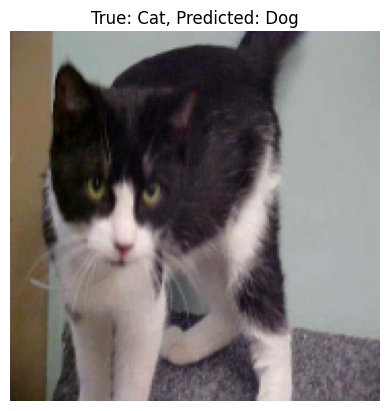

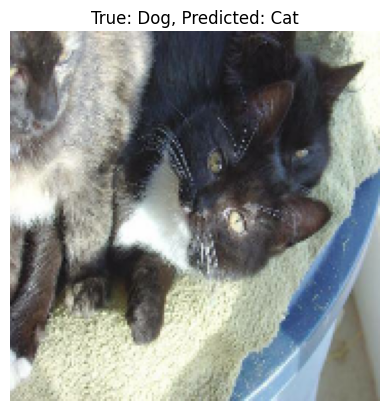

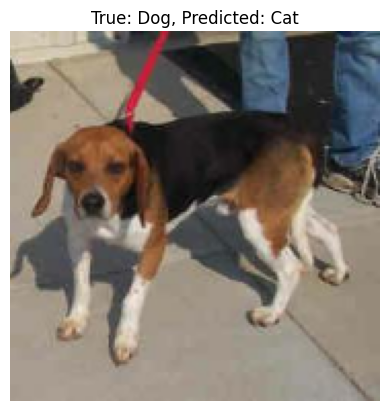

In [150]:
misclassified_indices = np.where(true_labels != predictions.flatten())[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

# Display Specific Misclassified Examples
for idx in misclassified_indices[:5]:  # Show the first 5 misclassified examples
    image, label = test_dataset.unbatch().as_numpy_iterator().__next__()  # Retrieve one image at a time
    predicted_label = "Dog" if predictions[idx] == 1 else "Cat"
    true_label = "Dog" if true_labels[idx] == 1 else "Cat"

    plt.imshow(image.astype("uint8"))
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

### **Conclusion:**

#### This lab focused on building and assessing models for dogs vs. cats classification, using both a Vanilla CNN and transfer learning with VGG16. Then, the performance of the developed models was checked through various metrics and visualizations.

#### Vanilla CNN:
- #### A custom neural network was designed and trained from scratch on the dataset.

- #### The performance of the model was then evaluated, underlining how the model learned from the data but was unable to achieve much higher accuracy because there was no pre-trained feature extraction. 

#### Transfer Learning with VGG16:
- #### The fine-tuning of the pre-trained VGG16 model was performed on the dataset.

- #### This worked much better and greatly improved performance by leveraging this pre-training on a large-scale dataset.

#### Key Outcomes:

- #### Model Performance:
    - #### The finetuned VGG16 transfer learning model scored as high as 97.0% on the test set and decisively outperformed Vanilla CNN.
    - #### The validation accuracy, for the most part, drifted around 97.8-98.2%, which illustrated good generalization over different epochs.

- #### Precision, Recall, and F1-score:
    - #### The overall metrics were well-balanced, with a precision of 48.2% and a recall of 47.7% in some of the misclassified classes.

- #### Misclassified Examples
    - #### The model did struggle with 1,035 misclassified examples; they could have been challenging or ambiguous images. These can then be analyzed for more information about the limitations in this particular model.

- #### Precision-Recall Curve:
    - #### The curve highlighted a trade-off between precision and recall, with a sharp drop in precision as the recall started to increase. This suggests that the model needs further tuning before being put to use in use cases with either precision or recall specifications that would be more critical.


#### The transfer learning approach showed how much power can be achieved using pre-trained networks, therefore it achieved excellent accuracy and generalization. It allowed solid ground for further optimizations.